# Prediccion de consesion de prestamos a potenciales clientes

## Planteando el caso hipotetico de una empresa de financiamiento de viviendas.

**_Housing Finance Company_** se dedica a todo tipo de préstamos para la vivienda. Tienen presencia en todas las zonas urbanas, semiurbanas y rurales.


### Metodo de solicitud de prestamo
El cliente primero solicita un préstamo hipotecario y después la empresa valida la elegibilidad del cliente para el préstamo. La empresa quiere automatizar el proceso de elegibilidad del préstamo basado en los detalles del cliente proporcionados al rellenar un formulario de solicitud en línea.
Estos datos son:
* sexo.
* estado civil.
* educación.
* personas a cargo.
* importe del préstamo.
* historial de crédito.
* Etc.

Se han proporcionado un conjunto para identificar los segmentos de clientes que son elegibles para los importes de los préstamos, de modo que puedan dirigirse específicamente a estos clientes.


### Metodo de resolucion del problema

Después de encontrar las tendencias ocultas, los patrones, y construir un modelo robusto mediante el aprendizaje de todos los tendencias y patrones, puede ser útil para predecir el estado del préstamo de los candidatos.
Se construira un modelo que ayude a comprobar y evaluar el prestamo segun el cliente, ya que la empresa necesita este tipo de herramienta.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import imblearn

In [2]:
plt.style.use('bmh')

In [3]:
# Importamos el dataset con el que quiero trabajar.
# Cargando el dataset para ser manipulado.

data = pd.read_csv("LoanData.csv")

In [4]:
# Quiero saber el tamaño del dataset con el que voy a trabajar y comprobar que se cargo bien.

data.shape

(614, 13)

In [5]:
# Revisando las columnas de mi dataset para saber como esta compuesto.

data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [6]:
# De lo anterior visto, determino que la columna objetivo sera "Loan_Status".
# Muestra de los primeros valores solo para asegurar que cargo bien.

data.head() 

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Entendimiento del conjunto de datos.

Con el dataset cargado y ya habiendo determinado la columna objetivo, deberia determinar cuales son las columnas independientes que me pueden ayudar a determinar que personas pueden acceder al prestamos y cuales no.
las columnas que podriamos analizar para saber si afectaran al otogarmiento podrian ser:
* Gender: *Hace referencia al genero del cliente*.
* Married:  *Hace referencia a si el cliente esta casado o no*.
* Dependents: *Hace referencia a las personas que tiene a cargo el cliente*.
* Education: *Hace referencia al nivel educativo del cliente*.
* Applicantincome: *Hace referencia a los ingresos del aplicante*.
* Coapplicantincome: *Hace referencia al garante del cliente a quien se le concderia el prestamo*.


In [7]:
# Realizando estadistica descriptiva para variables continuas (luego se hace con variables categoricas).
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Como vemos arriba, tenemos los datos descriptivos del dataset, como la cantidad de aplicantes, la media del importe del prestamo, la desviacion standard, y los maximos para cada elemento de las columnas.
Tambien es importante prestar atencion a los valores percentiles, que nos podran dar cuenta del efecto de los outliers dentro de mi dataset.


Está bastante claro que en las columnas "ApplicantIncome", "CoapplicantIncome" y "LoanAmount" estamos teniendo valores **atípicos**. Si nos fijamos bien en el valor medio y el valor máximo de la columna "ApplicantIncome" tiene una gran diferencia en el valor. 

Del mismo modo, se puede ver una gran diferencia en los valores de "CoapplicantIncome" y la columna "LoanAmount".

Los valores atípicos se consideran malos para los modelos de predicción, ya que estos valores atípicos pueden distorsionar o destruir el patron de aprendizaje de los datos, lo que podría conducir a un mal rendimiento de nuestro modelo.

In [8]:
# Haciendo estadistica descriptiva en columnas con valores categoricas.
# Esto me dara valores unicos y top de las variables categoricas ademas de la frecuencia con que ocurren.

data.describe(include='object')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


De lo anterior podemos ver un desbalance de los creditos entregados, ya que el valor de frecuencia top (es decir Y = ACEPTADO) es ampliamente superior a los N = NO ACEPTADOS.
Para comprobarlo vamos a contar los valores de la columna "Loan_Status".

In [9]:
# Confirmando los valores de la columna "Loan_Status".

data['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

## Limpieza de datos
Una vez ya entendido los datos que tenemos,vamos a pasar a buscar datos perdidos, faltantes y demas boludeces


In [10]:
# Comprobando faltante de datos en mi dataset, sumando los datos nulos por cada columna.
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Encontramos datos faltantes en las siguientes columnas:
### _(con variables categoricas)_
+ Gender
+ Married
+ Dependents
+ Self_Employed

### _(con variables numericas)_
+ LoanAmount
+ Loan_Amount_Term
+ Credit_History

Sabiendo de estos valores faltantes y el tipo de datos que estos contienen, podemos imputar o simplemente reemplazar esos valores por valores de media, mediana o moda.
    

Como sabemos que las columnas "Gender", "Married","Dependents" y "Self_Employed" son columnas con valores categoricas, podemos reemplazar los valores faltantes con la moda de su columna de la siguiente forma.

In [11]:
# Reemplazo de valores faltantes en columnas de valores categoricas.

data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])
data['Married'] = data['Married'].fillna(data['Married'].mode()[0])
data['Dependents'] = data['Dependents'].fillna(data['Dependents'].mode()[0])
data['Self_Employed'] = data['Self_Employed'].fillna(data['Self_Employed'].mode()[0])

Como sabemos que las columnas "LoanAmount", "Loan_Amount_Term" y "Loan_Amount_Term" son columnas con valores numericas, podemos reemplazar los valores faltantes con la media de su columna de la siguiente forma.

In [12]:
# Reemplazo de valores faltantes en columnas de valores numericos.

data['LoanAmount'] = data['LoanAmount'].fillna(data['LoanAmount'].median())
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].median())
data['Credit_History'] = data['Credit_History'].fillna(data['Credit_History'].median())

In [13]:
# Chequeando que ahora no tengamos ningun otro valor faltante

data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Podemos graficar los valores outliers para ver mas claro todo, sobre todo porque estaban en las columnas objetivo de estudio.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


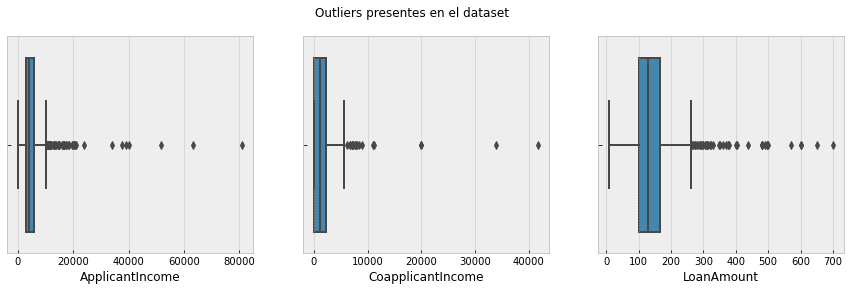

In [14]:
plt.rcParams['figure.figsize'] = (15, 4)

plt.subplot(1, 3, 1)
sns.boxplot(data['ApplicantIncome'])

plt.subplot(1, 3, 2)
sns.boxplot(data['CoapplicantIncome'])

plt.subplot(1, 3, 3)
sns.boxplot(data['LoanAmount'])

plt.suptitle('Outliers presentes en el dataset')
plt.show()


Una vez que ya ubicamos los outliers podemos ir sacandolos teniendo en cuenta los valores maximos y en donde se encuentran. Para eso voy a ir filtrando por cada columna objetivo.
Primero filtrando para la columna "ApplicantIncome" dejando con valores menores a 25000

In [15]:
# Removiendo outliers de columna 'ApplicantIncome'"

antes = data.shape
print("Antes de remover outliers de columna 'ApplicantIncome':",antes)

data = data[data['ApplicantIncome'] < 25000]

despues =data.shape
print("Despues de remover outliers de columna 'ApplicantIncome':", despues)

valoresEliminados = antes[0] - despues[0]
print("Cantidad de registros eliminados en el proceso:",valoresEliminados )

Antes de remover outliers de columna 'ApplicantIncome': (614, 13)
Despues de remover outliers de columna 'ApplicantIncome': (607, 13)
Cantidad de registros eliminados en el proceso: 7


Lo mismo hacemos para la columna "CoapplicantIncome", esta vez filtrando valores menores a 10000

In [16]:
# Removiendo outliers de columna 'CoapplicantIncome'"

antes = data.shape
print("Antes de remover outliers de columna 'CoapplicantIncome':", antes)

data = data[data['CoapplicantIncome'] < 10000]

despues = data.shape
print("Despues de remover outliers de columna 'CoapplicantIncome':", despues)

valoresEliminados = antes[0] - despues[0]
print("Cantidad de registros eliminados en el proceso:",valoresEliminados )

Antes de remover outliers de columna 'CoapplicantIncome': (607, 13)
Despues de remover outliers de columna 'CoapplicantIncome': (601, 13)
Cantidad de registros eliminados en el proceso: 6


Y por ultimo con la columna "LoanAmount" , filtrando en valores menores a 400

In [17]:
# Removiendo outliers de columna 'LoanAmount'"

antes = data.shape
print("Antes de remover outliers de columna 'LoanAmount':", antes)

data = data[data['LoanAmount'] < 400]

despues = data.shape
print("Despues de remover outliers de columna 'LoanAmount':", despues)

valoresEliminados = antes[0] - despues[0]
print("Cantidad de registros eliminados en el proceso:",valoresEliminados )

Antes de remover outliers de columna 'LoanAmount': (601, 13)
Despues de remover outliers de columna 'LoanAmount': (590, 13)
Cantidad de registros eliminados en el proceso: 11


## Analisis univariado
Para esta parte voy a graficar las columnas que contienen valores numericos

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

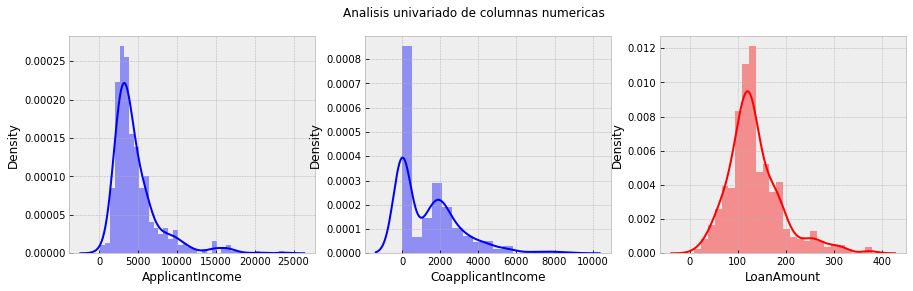

In [18]:
# Graficando columnas con datos numericos

plt.style.use('bmh')

plt.rcParams['figure.figsize'] = (15, 4)
plt.subplot(1,3, 1)
sns.distplot(data['ApplicantIncome'], color = 'blue')

plt.subplot(1,3, 2)
sns.distplot(data['CoapplicantIncome'], color = 'blue')

plt.subplot(1,3, 3)
sns.distplot(data['LoanAmount'], color = 'red')

plt.suptitle('Analisis univariado de columnas numericas')
plt.show()

Podemos ver que hay asimetria en los datos asi que vamos a aplicar algunmetodos de transformacion

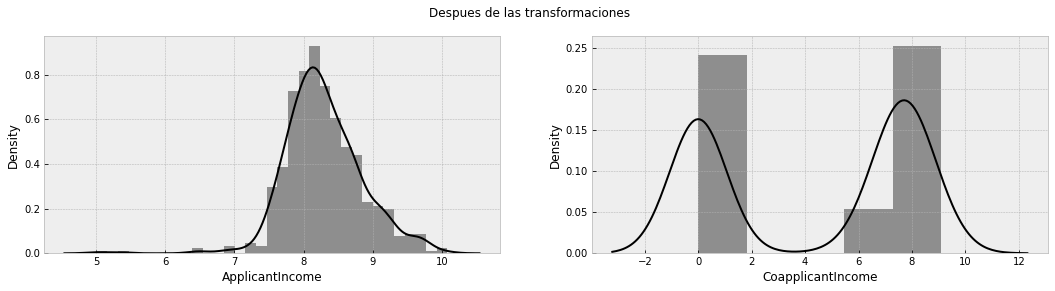

In [19]:
# Aplicando la libreria warnings

import warnings
plt.style.use('bmh')
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (18, 4)

# Aplicando transformacion para eliminar la asimetria
data['ApplicantIncome'] = np.log(data['ApplicantIncome'])
data['CoapplicantIncome'] = np.log1p(data['CoapplicantIncome'])

# Graficando para comprobar si la asimetria fue anulada
plt.subplot(1, 2, 1)
sns.distplot(data['ApplicantIncome'], color = 'black')

plt.subplot(1, 2, 2)
sns.distplot(data['CoapplicantIncome'], color = 'black')

plt.suptitle('Despues de las transformaciones')
plt.show()

Ya teniendo los datos numericos de la manera que necesito, voy a realizar el analisis univariado para las columnas que tiene valores categoricos.

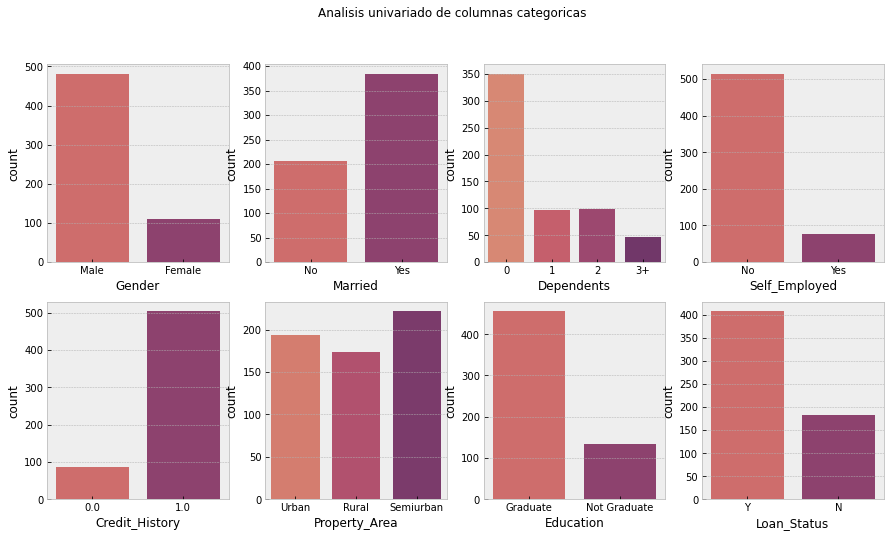

In [20]:
plt.rcParams['figure.figsize'] = (15,8)

plt.subplot(2, 4, 1)
sns.countplot(data['Gender'], palette = 'flare')

plt.subplot(2, 4, 2)
sns.countplot(data['Married'], palette = 'flare')

plt.subplot(2, 4, 3)
sns.countplot(data['Dependents'], palette = 'flare')

plt.subplot(2, 4, 4)
sns.countplot(data['Self_Employed'], palette = 'flare')

plt.subplot(2, 4, 5)
sns.countplot(data['Credit_History'], palette = 'flare')

plt.subplot(2, 4, 6)
sns.countplot(data['Property_Area'], palette = 'flare')

plt.subplot(2, 4, 7)
sns.countplot(data['Education'], palette = 'flare')

plt.subplot(2, 4, 8)
sns.countplot(data['Loan_Status'], palette = 'flare')

plt.suptitle('Analisis univariado de columnas categoricas')
plt.show()

## Analisis bivariado
Aplicando el analisis bivariado podemos realizar analisis de tipo categorico-numerico, categorico-categorico o numerico-numerico segun lo que necesitmos ver, en este caso vamos a analizar contra nuestra columna objetivo que es "Loan_Status".

Empiezo comparando a "Loan_Status" con  la columna "ApplicantIncome" (ambas son numericas).

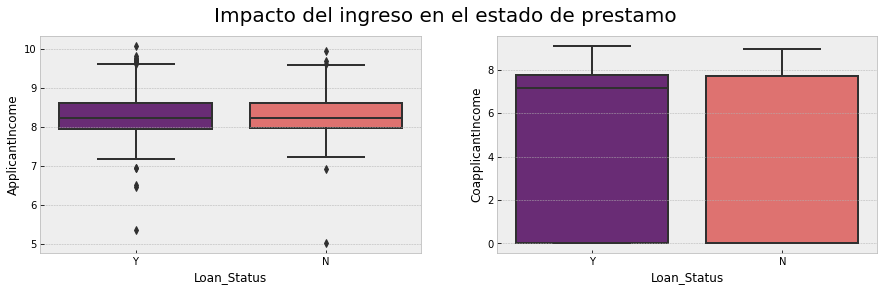

In [21]:
# Analizando el impacto de comparacion entre las columnas de "Loan_Status" y "ApplicantIncome"

plt.rcParams['figure.figsize'] = (15, 4)

plt.subplot(1, 2, 1)
sns.boxplot(data['Loan_Status'], data['ApplicantIncome'], palette = 'magma')

plt.subplot(1, 2, 2)
sns.boxplot(data['Loan_Status'], data['CoapplicantIncome'], palette = 'magma')

plt.suptitle('Impacto del ingreso en el estado de prestamo\n', fontsize = 20)
plt.show()

Analizando la comparacion de "Loan_Status" con "LoanAmount".

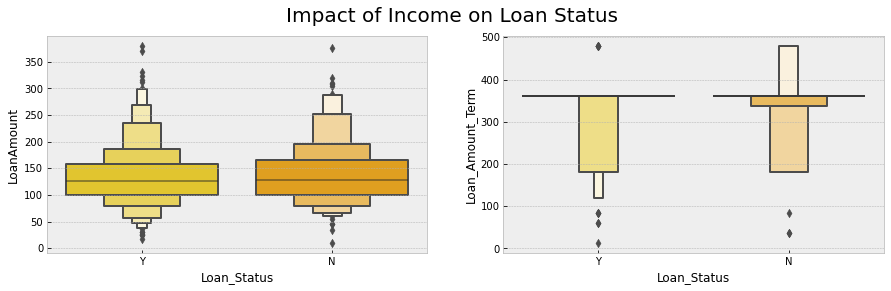

In [22]:
# Analizando el impacto de comparacion entre las columnas de "Loan_Status" y "LoanAmount"

plt.rcParams['figure.figsize'] = (15, 4)

plt.subplot(1, 2, 1)
sns.boxenplot(data['Loan_Status'], data['LoanAmount'], palette = 'Wistia')

plt.subplot(1, 2, 2)
sns.boxenplot(data['Loan_Status'], data['Loan_Amount_Term'], palette = 'Wistia')

plt.suptitle('Impact of Income on Loan Status\n', fontsize = 20)
plt.show()

Una vez analizadas las columnas numericas, debemos analizar las columnas categoricas, para eso usaremos "crosstab" para comprara dos variables (una categorica y la otra numerica)


In [23]:
# Comparando todas las categorias con la columna "Loan_Status" para entender el impacto de c/u.
print("Impacto del matrimonio en los préstamos")
print(pd.crosstab(data['Loan_Status'], data['Married']))
print('\n')

print("Impacto de clientes con personas a cargo en los préstamos ")
print(pd.crosstab(data['Loan_Status'], data['Dependents']))
print('\n')

print("Impacto de la educacion en los préstamos")
print(pd.crosstab(data['Loan_Status'], data['Education']))
print('\n')

print("Impacto del empleo en los préstamos")
print(pd.crosstab(data['Loan_Status'], data['Self_Employed']))
print('\n')

print("Impacto de la propiedad  en los préstamos")
print(pd.crosstab(data['Loan_Status'], data['Property_Area']))

Impacto del matrimonio en los préstamos
Married       No  Yes
Loan_Status          
N             76  106
Y            130  278


Impacto de clientes con personas a cargo en los préstamos 
Dependents     0   1   2  3+
Loan_Status                 
N            110  33  24  15
Y            240  63  74  31


Impacto de la educacion en los préstamos
Education    Graduate  Not Graduate
Loan_Status                        
N                 130            52
Y                 326            82


Impacto del empleo en los préstamos
Self_Employed   No  Yes
Loan_Status            
N              157   25
Y              357   51


Impacto de la propiedad  en los préstamos
Property_Area  Rural  Semiurban  Urban
Loan_Status                           
N                 66         51     65
Y                108        171    129


### Comentarios sobre el analisis bivariado de categorica - numerica

Del analisis anterior se desprenden algunos datos:

* Las personas casadas reciben en proporcion mayor la aprobacion de un credito o prestamo.
* La cantidad de personas a cargo del cliente influye de manera negativa para la obtencion de un prestamo.
* Las personas graduadas o de mayor educacion tienen mas chance de ser aprobados para un prestamo.
* Las personas  autoempleadas tienen en proporcion mayor chance de exito de recibir un prestamo aprobado.
* La proporcion de zonas semi-urbanas tienen mas prestamos aprobados.

## Preparacion de los datos para el modelo
Preparando los datos para el modelo voy a tener que convertir todos los valores del tipo "string" a valores numericos que pueda usar para el modelo de machine learning, asi que primero analizo el dataset teniendo en cuento aquellas columnas con valores del typo "object".

In [24]:
# Revisando las columnas que tienen valores tipo "object"
data.select_dtypes('object').head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y


Eliminando la columna "Loan_ID" ya que no aportara nada para el modelo

In [25]:
# Imprinedo el "shape" del dataset antes de eliminar la columna "Loan_ID"

antes = data.shape
print("Before Deleting Columns :",antes)

data = data.drop(['Loan_ID'], axis = 1)

#  Comprobando el "shape" del dataframe antes y despues
despues = data.shape
print("After Deleting Columns :", despues)

valoresEliminados = antes[1] - despues[1]
print("Cantidad de columnas eliminadas en el proceso:",valoresEliminados )

Before Deleting Columns : (590, 13)
After Deleting Columns : (590, 12)
Cantidad de columnas eliminadas en el proceso: 1


## Codificacion de los valores
Antes de codificar los valores usando el principio de _"One Hot Encoding"_ tengamos en cuenta lo siguiente (esto sera en base al anterior analisis de las variables categoricas y los graficos).

- La columna de "Gender" se separa en 1 y 0 para "Male" y "Female" respectivamente.
- La columna "Married" se separa en 1 y 0 para "Yes" y "No" respectivamente.
- La columna "Education" se separa en 1 y 0 para "Graduate" y "Not Graduate" respectivamente.
- La columna "Self_Employed" se separa en 1 y 0 para "Yes" y "No" respectivamente.
- La columna "Loan_Status" se separa en 1 y 0 para "Y" y "N" respectivamente.

### Criterio para datos de mas de un valor

- La columna "Property_Area" se separa en 1 para "Urban" y "Semiurban", mientras que'Rural' tendra el valor de 0 (esto es por la similitud de valores de "Urban" y "Semiurban").

- La columna "Dependents" se separa en 0 para "0" y en 1 para los valores "1", "2" y "3+" aplicando que los valores de "1", "2" y "3+" pertenecen a un grupo diferente de "0".


In [26]:
# Codificando las columnas

data['Gender'] = data['Gender'].replace(('Male','Female'),(1, 0))
data['Married'] = data['Married'].replace(('Yes','No'),(1, 0))
data['Education'] = data['Education'].replace(('Graduate','Not Graduate'), (1, 0))
data['Self_Employed'] = data['Self_Employed'].replace(('Yes','No'), (1, 0))
data['Loan_Status'] = data['Loan_Status'].replace(('Y','N'), (1, 0))


data['Property_Area'] = data['Property_Area'].replace(('Urban','Semiurban', 'Rural'),(1, 1, 0))

data['Dependents'] = data['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 1, 1))

# comprobacion de que no quedaron columnas por analizar
data.select_dtypes('object').columns

Index([], dtype='object')

Ahora separamos la columna target del dataset.

In [27]:
# separamos la columna target del dataset

y = data['Loan_Status']
x = data.drop(['Loan_Status'], axis = 1)

print("Forma de x :", x.shape)
print("Forma de y :", y.shape)

Forma de x : (590, 11)
Forma de y : (590,)


## Aplicacion de remuestreo
método que consiste en extraer muestras repetidas de las muestras originales. Como se vio anteriormente nuestra columna objetivo estaba desbalanceada y podemos corregir eso con metodo estadistico.

In [28]:
# Es muy importante remuestrear los datos, ya que la clase objetivo está muy desequilibrada.

from imblearn.over_sampling import SMOTE
x_resample, y_resample  = SMOTE().fit_resample(x, y.values.ravel())

# Mostrando el "shape" de x y de y despues del remuestreo
print(x_resample.shape)
print(y_resample.shape)

(816, 11)
(816,)


In [29]:
# Comprobemos también los conteos de valores de nuestra variable objetivo

print("Antes de remuestreo:")
print(y.value_counts())

print("*-*-*-*-*-*-*-*-*-*-*")

print("Despues de remuestreo:")
y_resample = pd.DataFrame(y_resample)
print(y_resample[0].value_counts())

Antes de remuestreo:
1    408
0    182
Name: Loan_Status, dtype: int64
*-*-*-*-*-*-*-*-*-*-*
Despues de remuestreo:
1    408
0    408
Name: 0, dtype: int64


Esto balancea los datos, ahora existe la misma cantidad de personas aceptadas para el prestamo que cantidad de personas rechazadas.

In [30]:
# Separando los datos para entenamiento y testeo

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)

# Mostrando los "shape" de los datos de entrenamiento y testeo
print("'Shape' de x Train :", x_train.shape)
print("'Shape' de y Train :", y_train.shape)
print("'Shape' de x Test :", x_test.shape)
print("'Shape' de y Test :", y_test.shape)

'Shape' de x Train : (652, 11)
'Shape' de y Train : (652, 1)
'Shape' de x Test : (164, 11)
'Shape' de y Test : (164, 1)


## Modelo de machine learning (logisitico y gradient boosting)

Definiremos que modelo se ajusta mejor a mi problema, para eso utilizo tanto un modelo de regresion logisitca como el modelo "gradient boosting".

### Con modelo de regresion logisitca:
Definimos el modelo y ademas el conjunto de datos de entrenamiento y testeo para el mismo. Comprobamos la precision tanto del testeo como del entrenamiento.

In [31]:
# Aplicando un modelo de regresion logitica

from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression(random_state = 0)
modelo.fit(x_train, y_train)

y_pred = modelo.predict(x_test)

print("Precisión de entrenamiento :", modelo.score(x_train, y_train))
print("Precisión de la prueba :", modelo.score(x_test, y_test))

Precisión de entrenamiento : 0.7868098159509203
Precisión de la prueba : 0.8292682926829268


La precision del entrenamiento esta al rededor del 78 % y del testeo en 82 %, hago la matriz de confusion para ver mas de cerca los datos

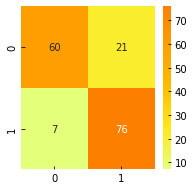

              precision    recall  f1-score   support

           0       0.90      0.74      0.81        81
           1       0.78      0.92      0.84        83

    accuracy                           0.83       164
   macro avg       0.84      0.83      0.83       164
weighted avg       0.84      0.83      0.83       164



In [32]:
# Analizandola perforamnce del modelo con matriz de confusion

from sklearn.metrics import confusion_matrix, classification_report

matriz = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(matriz, annot = True, cmap = 'Wistia', fmt = '.8g')
plt.show()

# Usando un reporte de clasificacion para el analisis de performance

reporte = classification_report(y_test, y_pred)
print(reporte)

Podemos ver que el modelo de regresión logística comete 21 errores al reconocer el rechazo del préstamo
mientras que sólo comete 7 errores al reconocer los casos de aceptación del préstamo.

Si echamos un vistazo a la precisión, podemos ver que la precisión para la clase cero es del 90%,
donde la posición para la clase uno es del 78%.Del mismo modo, el "recall" para la clase cero es del 74% y la clase uno es del 92%.

Esto significa que la regresión logística no es el mejor modelo para este conjunto de datos. Se aplicara otro tipo de modelo para ajustarse mejor.

### Con modelo gradient boosting

In [33]:
# Aplicando "gradient boosting"

from sklearn.ensemble import GradientBoostingClassifier

modelo =  GradientBoostingClassifier()
modelo.fit(x_train, y_train)

y_pred = modelo.predict(x_test)

print("Precisión de entrenamiento :", modelo.score(x_train, y_train))
print("Precisión de la prueba :", modelo.score(x_test, y_test))

Precisión de entrenamiento : 0.9156441717791411
Precisión de la prueba : 0.823170731707317


Los resultados previos son ligeramente mejores, pero aplico matriz de confusion para analizarlo mejor.

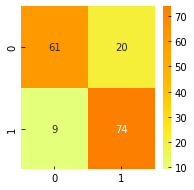

              precision    recall  f1-score   support

           0       0.87      0.75      0.81        81
           1       0.79      0.89      0.84        83

    accuracy                           0.82       164
   macro avg       0.83      0.82      0.82       164
weighted avg       0.83      0.82      0.82       164



In [34]:
# Analizandola perforamnce del modelo con matriz de confusion

matriz = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(matriz, annot = True, cmap = 'Wistia', fmt = '.8g')
plt.show()

# Usando un reporte de clasificacion para el analisis de performance

reporte = classification_report(y_test, y_pred)
print(reporte)

Aplicando validacion cruzada para confirmar los valores

In [35]:
from sklearn.model_selection import cross_val_score

gradiente = GradientBoostingClassifier(random_state = 0)
valores = cross_val_score(gradiente, x_train, y_train, cv=10)
print(valores)

[0.72727273 0.8030303  0.72307692 0.81538462 0.81538462 0.73846154
 0.84615385 0.75384615 0.81538462 0.81538462]


Si echamos un vistazo a la precisión y el "recall" son bastante similares.

Podemos comprobar las puntuaciones de la validación cruzada también y se puede ver que las puntuaciones no son demasiado importantes,lo que significa que el modelo ha sido entrenado bien.

No podemos esperar que este modelo funcione muy bien ya que el número de registros en los datos de entrenamiento es muy pequeño.
